What Makes a Poem Poetic?
===

Welcome! In this tutorial, you will curate a **poetry** corpus, and then analyze the linguistic features of these poems. The learning goal here is to assemble a rich set of natural language processing (NLP) tools to computationally validate linguistic theories around poetry this art form.

<img src="img/meter.jpg" />

---
** Motviation and Overview: **

No matter it's haiku, classical Chinese poetry or the sonnet, what makes a poem distinctive from other texts lies in both semantics and the style in which the semantics are expressed. Oxford dictinoary defines poetry as such:

> Poetry is a genre of literature <br> in which special intensity is given to the expression of feelings and ideas
<br> by the use of distinctive style and rhythm.

Poetry evokes emotion from the readers via a concentrated blend of sound and imagery. We want to analyze "diction", the poetic words and phrases through which this "_intensity of expression_" is achieved. We also want to computationally extract the "_distinctive structure and rhythm_" of poetry. In other words, this tutorial includes two subtasks:

1. **content** analysis, which is concerned with a poem's semantics and diction; 
2. **prosodic** analysis, which is concerned with the aesthetic rules that a poem follows, for instance, rhyme.

If the jargons here sound distancing, don't worry! You need no poetry study experience to be able to follow this tutorial. Yet I assume that you are already familiar with web scraping and/or have completed the previous NLP-related assignments of the course. 

Let's get started!

In [1]:
# utility packages
import numpy as np
from scipy import stats
import pandas as pd
import urllib.request
from random import seed, randint
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
from itertools import groupby
from prettytable import PrettyTable

# nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import DefaultTagger # POS tagger
from nltk.stem.porter import PorterStemmer

# poetry analysis
import Levenshtein
import poetrytools # https://github.com/hyperreality/Poetry-Tools

---
## 1 - Corpus Curation

Before curating our poetry corpus, let's first set up an object data structure to store the poems.
Note that you need to preserve line breaks (`<br/>` tags) when scraping the poems because they indicate poem structure. You shall also divide up sentences by the line breaks instead of punctutations.

In [2]:
class Poem():
    def __init__(self, url, name, author, lines, genre):
        self.source = url
        self.name = name
        self.author = author
        self.genre = genre
        self.lines = lines
        self.content = '\n'.join(lines)
        
        tokens = word_tokenize(self.content)
        self.dict = [w.lower() for w in tokens if w.isalpha()]
        
    def display(self):
        print('\n-------------------~~~ %s ~~~-------------------\n'%self.genre)
        print(self.name + '\n' + self.author + '\n')
        print(self.content)
        print('-----------------------------------------------------')

Now, you will scrape poems by author from [poemhunter.com](https://www.poemhunter.com/) in similar ways as you did with the Yelp reviews in assignment 1.

- Implement *collect_poems* function to access a poet's index page and loop over the links on this page to web pages that store each of his/her poems;
- Impelment *scrape_a_poem* function to collect the poem on each page;


In [3]:
def collect_a_poem(poem_url):
    """
    %output poem: a list of str, each str a line in a poem
    """
    # find the <p> tag where the poem text is stored
    # use tag.contents rather than tag.text to preserve <br/> tags
    lines = []
    
    soup = BeautifulSoup(urllib.request.urlopen(poem_url), "html5lib")
    tag = soup.find("div", id = "solSiirMetinDV").find("div", class_ = "KonaBody").find("p").contents

    for prose in tag:
        try:
            # read poem texts
            lines.append(prose.strip(' \t\n\r'))
        except:
            # ignore tags
            pass
    return lines

def collect_poems(poet_names):
    """
    Create a dictionary of all poems of the poet
    %param poet_names (list)
    %output poem_list (list of poem objects)
    """
    
    poem_list = []
    
    for poet_name in poet_names:
        
        # read a poet's index page
        poet = poet_name.lower().replace(' ', '-')
        poet_url = 'https://www.poemhunter.com/%s/poems/'%poet
        soup = BeautifulSoup(urllib.request.urlopen(poet_url), "html5lib")
        
        # check how many pages of poems does this poet has
        pages = int(soup.find("div", class_="pagination mb-15").find('ul').find_all("li")[-1].get_text())
        
        # loop over all pages
        for i in range(1, pages + 1):
            soup = BeautifulSoup(urllib.request.urlopen(poet_url + 'page-%d/'%i), "html5lib")
            
            # find links to his/her poems on this page
            for poemsoup in soup.find("table", class_="poems").tbody.findChildren():
                try:
                    poem_title = poemsoup.find("td",{"class":"title"}).find("a")['title']
                    poem_url = 'https://www.poemhunter.com/' + poemsoup.find("td",{"class":"title"}).find("a")['href']
                    poem_lines = collect_a_poem(poem_url)
                    poem_list.append(Poem(poem_url, poem_title, poet_name, poem_lines,'imagism'))
                except:
                    pass
                
    return poem_list

Now you can call `load_poems` to collect works of poets of your choice.

This tutorial used poems of [Ezra Pound](https://www.poemhunter.com/ezra-pound/poems/), [Amy Lowell](https://www.poemhunter.com/amy-lowell/poems/), [William Carlos Williams](https://en.wikipedia.org/wiki/William_Carlos_Williams) and [James Joyce](https://en.wikipedia.org/wiki/James_Joyce), all are celebrated [Imagist poets](https://en.wikipedia.org/wiki/Imagism). The rest of the tutorial will be based on this corpus, though it is flexible to be used in any other poetry genres and analysis!

In [4]:
imagist = collect_poems(['Ezra Pound', 'Amy Lowell', 'William Carlos Williams', 'James Joyce'])
print('%d imagism poems collected.'%len(imagist))

638 imagism poems collected.


In [7]:
# pickle the corpus in case of future use
import pickle
pickle.dump(imagist, open('imagist.p','wb'))

# uncomment to load the pickled corpus
# imagist = pickle.load(open("imagist.p",'rb'))

In [9]:
seed(5)

# randomly display a classic poem
i = randint(0, len(imagist))
imagist[i].display() 


-------------------~~~ imagism ~~~-------------------

All Day I Hear The Noise Of Waters
James Joyce

All day I hear the noise of waters
Making moan,
Sad as the sea-bird is when, going
Forth alone,
He hears the winds cry to the water's
Monotone.
The grey winds, the cold winds are blowing
Where I go.
I hear the noise of many waters
Far below.
All day, all night, I hear them flowing
To and fro.

-----------------------------------------------------


You can also add other publically available poetry corpora into your collection.
Here we add in [some Modern and Renaissance poems](https://www.kaggle.com/ultrajack/modern-renaissance-poetry/data). Again, note that you seperate lines by carriage return `\r\n` instead of punctuations.

In [10]:
classics_df = pd.read_csv('data/poems-from-poetryfoundation-org.csv', encoding = 'utf-8') 
classics_df['lines'] = classics_df['content'].apply(lambda content: [line for line in content.split('\r\n') if line != ""])

classics = []
for index, row in classics_df.iterrows():
    classics.append(Poem('poems-from-poetryfoundation-org.csv', row['poem name'], row['author'], row['lines'], 'classics'))

print('%d classic poems collected.'%len(classics))

573 classic poems collected.


In [11]:
# randomly display a classic poem
c = randint(0, len(classics))
classics[c].display()


-------------------~~~ classics ~~~-------------------

I Find no Peace
SIR THOMAS WYATT

I find no peace, and all my war is done.
I fear and hope. I burn and freeze like ice.
I fly above the wind, yet can I not arise;
And nought I have, and all the world I season.
That loseth nor locketh holdeth me in prison
And holdeth me notyet can I scape no wise
Nor letteth me live nor die at my device,
And yet of death it giveth me occasion.
Without eyen I see, and without tongue I plain.
I desire to perish, and yet I ask health.
I love another, and thus I hate myself.
I feed me in sorrow and laugh in all my pain;
Likewise displeaseth me both life and death,
And my delight is causer of this strife.
-----------------------------------------------------


Congratulations! You have successfully curated a poetry corpus. In the next chapter, we will start to analyze these poems computationally.

* * *
## 2 - Content Analysis

Words are to a poet what clay is to the sculptor, a tangible material. Diction, or word choice may reveal interesting characteristics of Imagism.
To capture these characteristics computationally, let's first create a dictionary for each corpus.

** Note: **

We removed the stop words when creating the diction. However we will preserve them in the Poem objects because stopwords often carry important rhythm in poetry. [Some](https://gist.github.com/sebleier/554280) even pointed out that the stopwords themselves are quite poetic-sounding.

In [12]:
def corpus_dict(lst):
    """
    list all words (including repeatition) contained in a list of Poem objects
    :param: poem objects (list)
    :output: list of words (list of str)
    """
    list_of_lists = [obj.dict for obj in lst] # list of list
    all_words = [word for sublist in list_of_lists for word in sublist]

    return [word for word in all_words if word not in set(stopwords.words('english'))]

img_diction = corpus_dict(imagist)
cls_diction = corpus_dict(classics)

Here is a quick overview of the two dictions.


In [13]:
dict_overview = PrettyTable(['', 'Imagism', 'Classics'])
dict_overview.add_row(['# of poems', len(imagist), len(classics)])
dict_overview.add_row(['avg # of words per poem',
                       round(len(img_diction)/len(imagist),2),
                       round(len(cls_diction)/len(classics), 2)])
dict_overview.add_row(['# of distinct words', len(set(img_diction)), len(set(cls_diction))])
dict_overview.add_row(['avg # of distinct words per 100 words',
                       round(len(set(img_diction))/len(img_diction) *100,2),
                       round(len(set(cls_diction))/len(cls_diction) *100,2)])
dict_overview.add_row(['most common words',
                       [tp[0] for tp in Counter(img_diction).most_common(3)],
                       [tp[0] for tp in Counter(cls_diction).most_common(3)]])

print(dict_overview)

+---------------------------------------+-------------------------+-------------------------+
|                                       |         Imagism         |         Classics        |
+---------------------------------------+-------------------------+-------------------------+
|               # of poems              |           638           |           573           |
|        avg # of words per poem        |          121.63         |          93.34          |
|          # of distinct words          |          14959          |          11079          |
| avg # of distinct words per 100 words |          19.28          |          20.71          |
|           most common words           | ['like', 'one', 'upon'] | ['love', 'thy', 'thou'] |
+---------------------------------------+-------------------------+-------------------------+


### 2.1 -  Diction Analysis

#### Vocabulary Richness:  Yule's K

We can already see that classic poetry contains a somewhat more diverse diction than imagnist ones, using more dictive words in average. Classic poetry seems also has a somewhat less common vocabulary, given words like "thy" and "thou" being the most frequently used words.

Let's go one step deeper here by breaking it down to two more sophisticated measures of vocabulary richness: Yule’s I characteristic. A statistician called G.U. Yule invented this method of measuring vocabulary richness _Yule’s K_ characteristic as well as its inverse, _Yule’s I_. 

Yule's K measures the likelyhood of two nouns, chosen at random from the text, being the same. That is, a K value of 300 means that for any pair of nouns chosen at random from the given text, there's a 1 in 300 chance that they will be the same [[2]](#References). Smaller the K is, the richer the vocabulary.

Let $N$ be the total number of words in a text, $V(N)$ be the number of distinct words, $V(m, N)$ be the number of words appearing $m$ times in the text, and $m_{max}$ be the largest frequency of a word. Yule’s K is then defined through the first and second moments of the vocabulary population distribution of $V(m, N)$ [[4]](#References):

\begin{equation*}
K   = C \frac{S_2 - S_1}{S_1^2} \\ K   = C \left( - \frac{1}{N} + \sum_{k=1}^{m_{max}} V(m, N)\frac{m}{N}^2 \right)
\end{equation*}

In [14]:
def yuleK(tokens):
    """
    :para: list of tokens (str)
    :return: yule's K (float, 2 decimal points)
    """
    token_counter = Counter(tokens)
    m1 = sum(token_counter.values())
    m2 = sum([freq ** 2 for freq in token_counter.values()])
    try:
        i = (m1*m1) / (m2-m1)
        return round(1/i * 10000,2)
    except ZeroDivisionError:
        return 0

Now let's calculate the K characteristics for our data.

In [15]:
yule_compare = PrettyTable(['', 'Imagism', 'Classics'])
yule_compare.add_row(['Yule\'s K', yuleK(img_diction), yuleK(cls_diction)])
print(yule_compare)

+----------+---------+----------+
|          | Imagism | Classics |
+----------+---------+----------+
| Yule's K |   6.69  |   9.98   |
+----------+---------+----------+


** Caveat: **

Many most-commonly used measures of text complexity/sophistication do _not_ apply to poetry analysis. For example,  Flesch-Kincaid grade level. The intuition of this measure is that a text is more difficult to read if 1) there are more words in a sentence on average, and 2) the words are longer, or have more syllables. It makes #words/#sentences and #syllables/#words important terms in both metrics.

$$\text{Flesch-Kincaid grade level} = (0.39 \times \frac{number\ of\ words}{number\ of\ sentences}) + (11.8 \times \frac{number\ of\ syllables}{number\ of\ words}) - 15.59$$

However, as you may easily imagine, poems follow particular rules of "sentence" length. To use measures similar to Flesch-Kincaid readability measures, make sure the texts are of equal/similar length.

### 2.2 - Psycholinguistic Measures

Beyond word sophistication and richness, let's look into the linguistic style and psychological effects of poems of different genres.

<img src="img/def.jpg" />

The first tenet of Imagism poetry is "concrete imagery" [[1]](#References). This term revealed two defining characters of imagnism diction: One is "exactness" or "concreteness" (how “palpable” the
object the word refers to); the other is "imagibility" (the intensity with which a word arouses images).

> "_It's a graphic description or representation of an object so vividly rendered that its reality seems immediate, whether subjective or objective. It is a vehicle to build a mood or to convey feeling or thought._"



For these psycholinguistic measures, we will use the [MRC Psycholinguistic Database](http://websites.psychology.uwa.edu.au/school/MRCDatabase/uwa_mrc.htm) (Wilson, 1988). 

** MRC Psycholinguistic Database **

We will use a [modern port of the MRC Psycholinguistics Database Machine Usable Dictionary available on Github](https://github.com/samzhang111/mrc-psycholinguistics). To do so, install `sqlalchemy` via anaconda `conda install -c anaconda sqlalchemy`. Clone the repository to current directory by running `pip install gitpython` in Terminal.

    > cd your/current/directory
    > git clone git@github.com:samzhang111/mrc-psycholinguistics.git
    
Now you should find a "mrc-psycholinguistics" folder in the same directory of this Tutorial file. The MRC dictionary is stored in `mrc2.dct`. The dictionary contains a long list of psycholinguistic measures of 150,837 word entries and we highlight five of them that represent the defining psycholinguistic features of Imagnism poetry:

- **conc**: concreteness (i.e., perceptions of how abstract a word is);
- **fam**: familiarity (i.e., judgments of how familiar words are to adults);
- **img**: imageability (i.e., judgments of how easy it is to imagine a word). The MRC database contains imageability ratings for 4, 954 words (Coltheart, 1981);
- **meanc**: meaningfulness Colorado Norms (i.e., judgments of how related a word is to other words).

These measures look like this in the MRC2 database:

    0500000000000000000000000000000000000000000 N AS   &ARRY|||  
    0600000000000000000000000000000000000000000 N AS   &CELLO|||  
 
See the [MRC database documentation](http://websites.psychology.uwa.edu.au/school/MRCDatabase/mrc2.html) for detailed encoding of each feature. Accordingly, now let's parse the relevant features in MCR databse and store them in a dictionary.

In [16]:
mrc_dict = {}

for a in open('mrc-psycholinguistics/mrc2.dct'):
    cols = a.split(' ', 1)
    b = list(cols[0])
    conc = int(b[28] + b[29] + b[30]) # concreteness rating
    imag = int(b[31] + b[32] + b[33]) # imagery rating
    fam = int(b[25] + b[26] + b[27]) # familiarity rating
    meanc = int(b[34] + b[35] + b[36]) # meaningfulness rating #1
    mean2 = int(b[37] + b[38] + b[39]) # meaningfulness rating #2
    try:
        word, phon, dphon, stress = cols[1][:-1].split(' ')[4].split('|')
        mrc_dict[word] = (fam, conc, imag, meanc, stress)
    except:
        pass

print('Parsed the MRC psycholingstic dictionary of %d words'%len(mrc_dict))

Parsed the MRC psycholingstic dictionary of 31519 words


Create a lookup function to qurey a single word's psycholinguistic features.

** Notes: ** 

- The "word" in the MCR database encodes regex. For instance, word $ARRY should respond to all words that end with "arry";
- The query does _not_ differernciate capitalization. See [here](http://docs.sqlalchemy.org/en/latest/orm/session_basics.html#querying) for detailed instructions to query the dictionary using sqlalchemy sessions.




In [19]:
def query_word_mrc(word, mrc_dict = mrc_dict):
    """
    access the psycholinguistic features of a word from mrc dictionary
    :para: a word (str)
    :output: the word's concretness, familiarity, imageability, meaningfulness, stress pattern (tuple of int)
    """
    try: 
        return mrc_dict[word.upper()]
    except:
        return (0,0,0,0,0)

test_word = "strawberry"
print("Example: %s"%test_word)
print('Familiarity %d \nConcreteness %d \nImageability %d \nMeaningfulness %d \nStress Pattern %s'%query_word_mrc(test_word))

Example: strawberry
Familiarity 539 
Concreteness 610 
Imageability 631 
Meaningfulness 465 
Stress Pattern 200


#### Concrete Imagery, Abstract Metaphors

Look up the psycholinguistic measures of every word in the diction of imagist and classic poems. Let's start with a quick-and-dirty "bag of words" comparison between the distribution of these measures. 

In [69]:
def describe_diction(diction):
    """
    access psycholinguistic features of all words in a diction
    """
    lst = list(map(query_word_mrc, diction)) # list of tuples
    
    # remove measures of words that are not in the MRC database
    lst.remove((0,0,0,0,0))
    fam, conc, imag, meanc, stress = map(list, zip(*lst))
    
    fam.remove(0)
    conc.remove(0)
    imag.remove(0)
    meanc.remove(0)

    return (fam, conc, imag, meanc, stress)

img_fam, img_conc, img_imag, img_meanc, img_stress = describe_diction(img_diction[:10])
cls_fam, cls_conc, cls_imag, cls_meanc, cls_stress = describe_diction(cls_diction[:10])

When visualizing these measures, you shall take into consideration its valid range [[5]](http://websites.psychology.uwa.edu.au/school/MRCDatabase/mrc2.html#CONC) and its common distribution in natural human conversations.
    > CONC values -- min: 158, max 670, mean 438, s.d. 120;
    > MEANC values (meaningfulness) -- min 127; max 667, mean 415; s.d. 78;
    > IMAG (imageability) -- min 129; max 669; mean 450, s.d. 108;
    > FAM (familiarity) -- max 657, mean 488, s.d. 99.

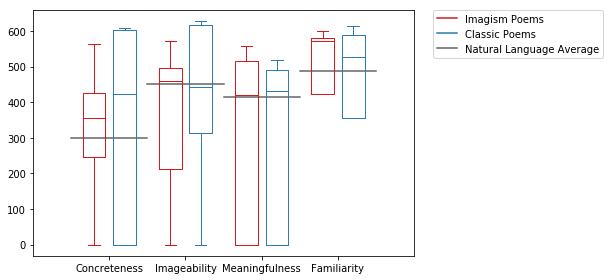

In [73]:
import matplotlib.pyplot as plt
import numpy as np

img = [img_conc, img_imag, img_meanc, img_fam]
cls = [cls_conc, cls_imag, cls_meanc, cls_fam]

ticks = ['Concreteness', 'Imageability', 'Meaningfulness', 'Familiarity']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(img, positions=np.array(range(len(img)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(cls, positions=np.array(range(len(cls)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Imagism Poems')
plt.plot([], c='#2C7BB6', label='Classic Poems')
plt.plot([], c ='#636363', label='Natural Language Average')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# draw horizontal lines
plt.axhline(y=300,xmin=0.1,xmax=0.3,c ='#636363',zorder=0) #conc
plt.axhline(y=450,xmin=0.3,xmax=0.5,c ='#636363',zorder=0) #imag
plt.axhline(y=415,xmin=0.5,xmax=0.7,c ='#636363',zorder=0) #meanc
plt.axhline(y=488,xmin=0.7,xmax=0.9,c ='#636363',zorder=0) #fam

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.tight_layout()
plt.savefig('img/psycholinguistic-comparison.png')

As the visualization vividly shows, poets utilizes a vocabulary that's visibly more concrete and familiar-feeling than day-to-day English language. However, their word, though common, choices deliver imagery loaded with meaning. This fits perfectly with how literature theory defines poetry [[6]](http://webs.anokaramsey.edu/stankey/Literat/Poetry/Imagism.htm):
> Use the language of common speech but to employ always the exact word, not the nearly-exact.

---
## 3 - Prosodic Analysis: The Musicality of Poetry

Poets convey and reinforce the meaning or experience of poetry through the skillful use of sound. , a poem creates an emotional response. All in all, it invites you, the reader, to sense a particular thing, and the use of _sound devices_ are some of the poet’s tools.

#### Rhyme Scheme and Metre

Our `wd_psylin` function aobve returns a not-yet-utlized word measure 'stress pattern'. We can use this measure to visualize poetry rhythm. Concretely, vowels are marked for stress:

    > Phoneme Example Translation
    > ------- ------- -----------
    > OW      oat     OW T
    > N       knee    N IY

Here we take it one step furthuer, using [poetrytools](https://github.com/hyperreality/Poetry-Tools) to perform more sophisticated prosodic analysis. It estimates the rhyme scheme and metre using [The Carnegie Mellon Pronouncing Dictionary in NLTK](http://www.nltk.org/_modules/nltk/corpus/reader/cmudict.html). 

** Note: ** 
We preserve all stopwords in prosodic analysis because they are important vehicles for rhyming and meter as well.

In [111]:
# randomly display a classic poem
seed = 60
c = randint(0, len(classics))

a_poem = poetrytools.tokenize(classics[c].content)
a_metre = poetrytools.scanscion(a_poem)
print(poetrytools.guess_form(a_poem, verbose=True))

Metre: 1111010011 0101011101 1111001101 1011011101 11010001111 1101011011 100111110 1101101101 01010010011 1001010011 000101011 1101011111 11011111010 1111011001
Rhyme scheme: ababcdcdbXbXcc
Stanza lengths: 14

Closest metre: iambic trimeter
Closest rhyme: shakespearean sonnet
Closest stanza type: sonnet
Guessed form: sonnet with unusual meter


Finally, randomly select a poem from the corpora, and annotate its metre just as the header image of this tutorial did. Do the rhythm and rhyming structures modeled by poetrytools reflect your experience?

In [112]:
for line in zip(classics[c].lines, a_metre):
    print(line[0], '\n', '  -  '.join(line[1]), '\n')

Let those who are in favour with their stars 
 1  -  1  -  1  -  1  -  0  -  10  -  0  -  1  -  1 

Of public honour and proud titles boast, 
 0  -  10  -  10  -  1  -  1  -  10  -  1 

Whilst I, whom fortune of such triumph bars, 
 1  -  1  -  1  -  10  -  0  -  1  -  10  -  1 

Unlook'd for joy in that I honour most. 
 10  -  1  -  1  -  0  -  1  -  1  -  10  -  1 

Great princes' favourites their fair leaves spread 
 1  -  10  -  1000  -  1  -  1  -  1  -  1 

But as the marigold at the sun's eye, 
 1  -  1  -  0  -  101  -  1  -  0  -  1  -  1 

And in themselves their pride lies buried, 
 1  -  0  -  01  -  1  -  1  -  1  -  10 

For at a frown they in their glory die. 
 1  -  1  -  0  -  1  -  1  -  0  -  1  -  10  -  1 

The painful warrior famoused for fight, 
 0  -  10  -  100  -  100  -  1  -  1 

After a thousand victories once foil'd, 
 10  -  0  -  10  -  100  -  1  -  1 

Is from the book of honour razed quite, 
 0  -  0  -  0  -  1  -  0  -  10  -  1  -  1 

And all the 

## Appendix

#### References
1. Stillman, F., & Whitfield, J. S. (1965). The poet's manual and rhyming dictionary: Based on The improved rhyming dictionary. Ty Crowell Co.
2. cf. Oakes, M.P. 1998. Statistics for Corpus Linguistics. International Journal of Applied Linguistics, Vol 10 Issue 2.
3. Slater, E. (1988). The Problem of The Reign of King Edward III: A Statistical Approach. Cambridge University Press.
4. Tanaka-Ishii, K., & Aihara, S. (2015). Computational Constancy Measures of Texts—Yule's K and Rényi's Entropy. Computational Linguistics, 41(3), 481-502.
5. Tsvetkov, Y., Boytsov, L., Gershman, A., Nyberg, E., & Dyer, C. (2014). Metaphor detection with cross-lingual model transfer. In Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (Vol. 1, pp. 248-258).

** Additional Materials: **

- Affective Meanings: Arousal, Valence, Dominance

A deeper analysis may more accurately extrapolate the affective meanings of words. Prior work in psycholinguistics show that there is a close connection between the emotions felt by humans and the words they read in a text. The following three linguistic characteristics contribute to how the meanings of words affect human psychology, and often referred to as the affective meanings of words. This [computational analysis of poetic style Imagism and its influence on modern professional and amateur poetry paper](https://web.stanford.edu/~jurafsky/pubs/lilt15.pdf) offers a good introduction to analzing these affective qualities of poetry:

    - Valence (the pleasantness of the stimulus)
    - Arousal (the intensity of emotion provoked by the stimulus)
    - Dominance (the degree of control exerted by the stimulus)

- Our analysis of imagiability is somewhat naive. With word embeddings and other more sophisticated NLP algorithms, you will be able to explore more symbolic meanings of poetry language. Here are some tools useful to such analysis:
    - [Word2vec tutorial](http://nbviewer.jupyter.org/github/danielfrg/word2vec/blob/master/examples/word2vec.ipynb)
    - [Pre-trained word embeddings](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/)
    - [WordNet: concept-semantic mapping](https://wordnet.princeton.edu/)

- You may find a larger set imagnist poems in [Kao & Jurafsky, 2015](https://web.stanford.edu/~jurafsky/pubs/lilt15.pdf).



** Image credit: **

- http://journals.openedition.org/ebc/docannexe/image/2797/img-1-small480.jpg
- https://jvbirch.com/2016/09/30/national-poetry-day/